# Data Scientist Capstone - Starbucks Project

#### Step 1) Loading the necessary libraries and plotting tools

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.color_palette()

from sklearn import cluster
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report,f1_score
from sklearn.linear_model import LogisticRegression


import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "pgf.preamble": "\n".join([
         r"\usepackage[utf8x]{inputenc}",
         r"\usepackage[T1]{fontenc}",
         r"\usepackage{cmbright}",
    ]),
})

font = {'family' : 'Helvetica',
        'weight' : 'ultralight',
        'size'   : 10}
plt.rc('font', **font)

%matplotlib inline

#### Step 2) Loading Starbucks datasets (Portfolio, Profile and Transcript)

In [2]:
# read the data files (json files)
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
# portfolio.json**
# * id (string) - offer id
# * offer_type (string) - type of offer ie BOGO, discount, informational
# * difficulty (int) - minimum required spend to complete an offer
# * reward (int) - reward given for completing an offer
# * duration (int) - time for offer to be open, in days
# * channels (list of strings)

portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [3]:
# show the portfolio head data
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


#### Q1: How many offers are offers by Starbucks to its customers/members?

In [4]:
print('Number of available offers is: ', len(portfolio['id'].unique()))

Number of available offers is:  10


In [5]:
profile = pd.read_json('data/profile.json', orient='records', lines=True)
# profile.json**
# * age (int) - age of the customer 
# * became_member_on (int) - date when customer created an app account
# * gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
# * id (str) - customer id
# * income (float) - customer's income

profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [6]:
# show the profile header data
profile.head(10)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


#### Q2: How many customers are available in Starbucks data?

In [7]:
# check the unique number of customer id in the profile dataframe
print('Number of unique customers in the profile dataframe is: ',len(profile['id'].unique()))

Number of unique customers in the profile dataframe is:  17000


In [8]:
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)
# transcript.json**
# * event (str) - record description (ie transaction, offer received, offer viewed, etc.)
# * person (str) - customer id
# * time (int) - time in hours since start of test. The data begins at time t=0
# * value - (dict of strings) - either an offer id or transaction amount depending on the record

transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [9]:
transcript.head(10)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


#### Step 3) Processing the portfolio data and extract values from channels column.

In [10]:
# stacking the channels columns and remove it frame dataframe
# renaming the id column to offer_id
portfolio = pd.concat([portfolio, pd.get_dummies(portfolio['channels'].apply(pd.Series).stack()).sum(level=0)], axis=1)
portfolio = portfolio.drop(columns='channels')
portfolio = portfolio.rename(columns={'id':'offer_id'})
portfolio.head(10)

/var/folders/lq/fd263pl95vl70br52q7qp9xr0000gn/T/ipykernel_91205/1085287124.py:3: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  portfolio = pd.concat([portfolio, pd.get_dummies(portfolio['channels'].apply(pd.Series).stack()).sum(level=0)], axis=1)


,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


#### Q3:  What is the number of offer provided as email to customer?

In [11]:
portfolio['email'].sum()

10

As all values in the email column of the portfolio dataframe only has values equal to '1' it might not help for modelling the data.


#### Q4: What is property (gender and income) of members/customers who has age 118?

In [12]:
# checking for missing values (NaNs)
# find out gender and income for the customers who have age 118
profile[profile.age == 118][['gender','age','income']].head(5)

,gender,age,income
0,None,118,NaN
2,None,118,NaN
4,None,118,NaN
6,None,118,NaN
7,None,118,NaN


In [13]:
print('Number of customers with age = 118 is: ',len(profile[profile.age == 118][['gender','age','income']]))
print('Number of customers with gender as NaN is: ',profile['gender'].isnull().sum())
print('Number of customers with income as NaN is: ',profile['income'].isnull().sum())

Number of customers with age = 118 is:  2175
Number of customers with gender as NaN is:  2175
Number of customers with income as NaN is:  2175


#### Q5: What are different genders in the profile data?

In [14]:
# checking the unique values of the 'gender' column
profile['gender'].unique()

array([None, 'F', 'M', 'O'], dtype=object)

#### Q6: What is the customers in profile data with genders as NaN?

In [15]:
# checking the missing value of the 'gender' column
profile['gender'].isna().sum()

2175

In [16]:
# formatting membership date column to readable data format
# renaming the id column in the profile dataframe to customer_id
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile = profile.rename(columns={'id':'customer_id'})
profile.head(10)

,gender,age,customer_id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,2017-10-02,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,2016-11-22,NaN


In [17]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  object        
 1   age               17000 non-null  int64         
 2   customer_id       17000 non-null  object        
 3   became_member_on  17000 non-null  datetime64[ns]
 4   income            14825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 664.2+ KB


#### Step 4) Converting the membership date to year, month and day

In [18]:
# creating membership year, month and day 
profile[["year", "month","day"]] = profile["became_member_on"].astype(str).str.split("-", expand = True).astype(int)
profile.head()

,gender,age,customer_id,became_member_on,income,year,month,day
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,2017,2,12
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,15
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,2018,7,12
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5,9
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,2017,8,4


In [19]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  object        
 1   age               17000 non-null  int64         
 2   customer_id       17000 non-null  object        
 3   became_member_on  17000 non-null  datetime64[ns]
 4   income            14825 non-null  float64       
 5   year              17000 non-null  int64         
 6   month             17000 non-null  int64         
 7   day               17000 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 1.0+ MB


#### Step 5) Preprocessing transcript data, including renaming and relabeling columns

In [20]:
# rename the person column in the transcripts dataframe to customer_id
transcript.rename(columns={'person': 'customer_id'}, inplace=True)

# Expand dictionary values to be dataframe columns
transcript['offer_id'] = transcript.value.apply(lambda x: x.get('offer id'))

# Renaming and relabeling event column name
transcript['event'] = transcript['event'].str.replace(' ', '_')
transcript = pd.concat([transcript, pd.get_dummies(transcript['event'])], axis=1 )

# Dropping the value column
transcript.drop(['value'], axis=1, inplace=True)

# Replace 'None' and 'NaN' with 0 values
transcript.fillna(0, inplace=True)

transcript.head(10)

,customer_id,event,time,offer_id,offer_completed,offer_received,offer_viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer_received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer_received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer_received,0,2906b810c7d4411798c6938adc9daaa5,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer_received,0,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer_received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0,0
5,389bc3fa690240e798340f5a15918d5c,offer_received,0,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0,0
6,c4863c7985cf408faee930f111475da3,offer_received,0,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,0,0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer_received,0,3f207df678b143eea3cee63160fa8bed,0,1,0,0
8,aa4862eba776480b8bb9c68455b8c2e1,offer_received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0
9,31dda685af34476cad5bc968bdb01c53,offer_received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0


#### Step 6) Mergig the transcript, profile and portfolio datasets to a single dataframe

In [21]:
# concatenating dataframes profile, transcript and portfolio into one dataframe
df = pd.merge(pd.merge(transcript, profile, on='customer_id'), portfolio, on='offer_id', how='left')
df.head(5)

,customer_id,event,time,offer_id,offer_completed,offer_received,offer_viewed,transaction,gender,age,...,month,day,reward,difficulty,duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer_received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,F,75,...,5,9,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer_viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,1,0,F,75,...,5,9,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,0,0,0,0,1,F,75,...,5,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer_completed,132,0,1,0,0,0,F,75,...,5,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,0,0,0,0,1,F,75,...,5,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Step 7) Mapping the offer_id in the dataframe and replace them with numeric values

In [22]:
# unique offers in the dataframe
offer_ids = df['offer_id'].unique()
offer_ids

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9', 0,
       '5a8bc65990b245e5a138643cd4eb9837',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '3f207df678b143eea3cee63160fa8bed',
       '2906b810c7d4411798c6938adc9daaa5',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       '2298d6c36e964ae4a3e7e9706d1fb8c2'], dtype=object)

In [23]:
# mapping the offer_id to numeric values instead keeping as str in the dataframe
offer_map = pd.Series(offer_ids).to_dict()
offer_map = dict([(value, key) for key, value in offer_map.items()]) 
offer_map

{'9b98b8c7a33c4b65b9aebfe6a799e6d9': 0,
 0: 1,
 '5a8bc65990b245e5a138643cd4eb9837': 2,
 'ae264e3637204a6fb9bb56bc8210ddfd': 3,
 'f19421c1d4aa40978ebb69ca19b0e20d': 4,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 5,
 '3f207df678b143eea3cee63160fa8bed': 6,
 '2906b810c7d4411798c6938adc9daaa5': 7,
 'fafdcd668e3743c1bb461111dcafc2a4': 8,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 9,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 10}

In [24]:
# mapping the offer_id to numeric values instead keeping as str in the dataframe
df['offer_id'] = df['offer_id'].map(offer_map)
df.head(5)

,customer_id,event,time,offer_id,offer_completed,offer_received,offer_viewed,transaction,gender,age,...,month,day,reward,difficulty,duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer_received,0,0,0,1,0,0,F,75,...,5,9,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer_viewed,6,0,0,0,1,0,F,75,...,5,9,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,1,0,0,0,1,F,75,...,5,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer_completed,132,1,1,0,0,0,F,75,...,5,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,1,0,0,0,1,F,75,...,5,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   customer_id       306534 non-null  object        
 1   event             306534 non-null  object        
 2   time              306534 non-null  int64         
 3   offer_id          306534 non-null  int64         
 4   offer_completed   306534 non-null  uint8         
 5   offer_received    306534 non-null  uint8         
 6   offer_viewed      306534 non-null  uint8         
 7   transaction       306534 non-null  uint8         
 8   gender            272762 non-null  object        
 9   age               306534 non-null  int64         
 10  became_member_on  306534 non-null  datetime64[ns]
 11  income            272762 non-null  float64       
 12  year              306534 non-null  int64         
 13  month             306534 non-null  int64         
 14  day 

### Analysis of the data provided by the Starbucks and make some feeling from the data

#### Q7: What is the distribution of offers, their difficulty and duration?

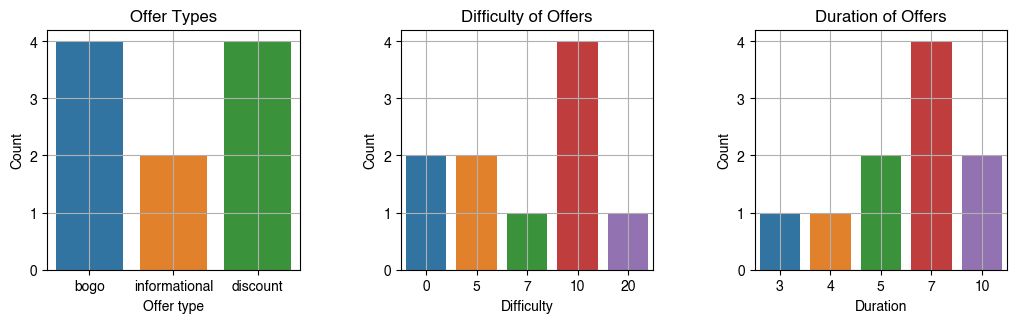

In [26]:
fig = plt.gcf()
fig.set_size_inches(12,3)
fig.tight_layout(pad=5.0)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

plt.subplot(131)
sns.countplot(x='offer_type', data=portfolio)
plt.ylabel('Count')
plt.xlabel('Offer type')
plt.title('Offer Types')
plt.grid(True)

plt.subplot(132)
sns.countplot(x='difficulty', data=portfolio)
plt.ylabel('Count')
plt.xlabel('Difficulty')
plt.title('Difficulty of Offers')
plt.grid(True)

plt.subplot(133)
sns.countplot(x='duration', data=portfolio)
plt.ylabel('Count')
plt.xlabel('Duration')
plt.title('Duration of Offers')
plt.grid(True)

#### Q8: What is the portion of female and male customer in the dataframe?

In [27]:
total_count = df['gender'].value_counts()[0] + df['gender'].value_counts()[1] + df['gender'].value_counts()[2]

male_count   = df['gender'].value_counts()[0] / total_count*100
female_count = df['gender'].value_counts()[1] / total_count*100
others_count = df['gender'].value_counts()[2] / total_count*100

print('Portion of female members in the dataset: ',"{:.2f}".format(female_count),'%')
print('Portion of male members in the dataset:   ',"{:.2f}".format(male_count), '%')
print('Portion of other members in the dataset:   ',"{:.2f}".format(others_count), '%')


Portion of female members in the dataset:  41.47 %
Portion of male members in the dataset:    57.08 %
Portion of other members in the dataset:    1.46 %


#### Q9: What is the distribution of age and income of the customers?

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


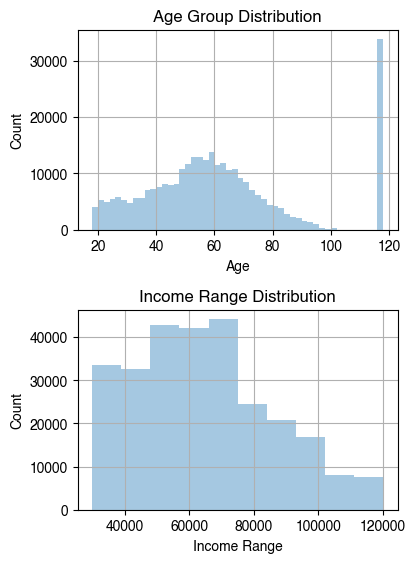

In [28]:
fig = plt.gcf()
fig.set_size_inches(4,6)
fig.tight_layout(pad=5.0)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.25,
                    hspace=0.4)

plt.subplot(211)
sns.distplot(df['age'], kde=False)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Group Distribution')
plt.grid(True)

plt.subplot(212)
sns.distplot(df['income'], kde=False,bins=10)
plt.xlabel('Income Range')
plt.ylabel('Count')
plt.title('Income Range Distribution')
plt.grid(True)

#### Q10: What is the gender and membership distribution?

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


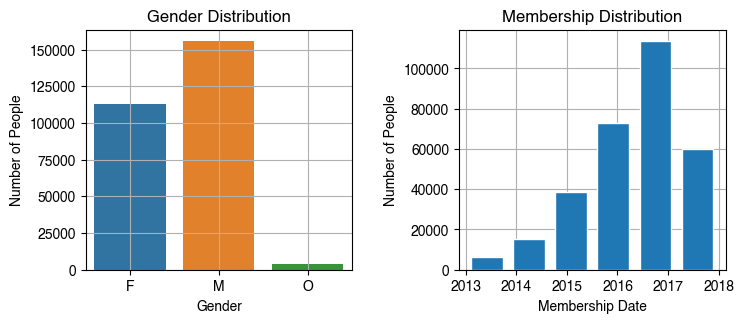

In [29]:
fig = plt.gcf()
fig.set_size_inches(8,3)
fig.tight_layout(pad=5.0)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

plt.subplot(121)
sns.countplot(df['gender'])
plt.ylabel('Number of People')
plt.xlabel('Gender')
plt.title('Gender Distribution')
plt.rc('axes', axisbelow=True)
plt.grid(True)


plt.subplot(122)
sns.distplot(df['became_member_on'].dt.year, bins = 6, kde=False, hist_kws={"rwidth":0.75,'edgecolor':'white', 'alpha':1.0})
plt.xlabel('Membership Date')
plt.ylabel('Number of People')
plt.title('Membership Distribution')
plt.rc('axes', axisbelow=True)
plt.grid(True)

The first and last year of membership year of customers?

In [30]:
print('Last membership year is', np.max(df['year']))
print('First membership year is', np.min(df['year']))

Last membership year is 2018
First membership year is 2013


#### Q11: What is the distribution of female and male age and their income?

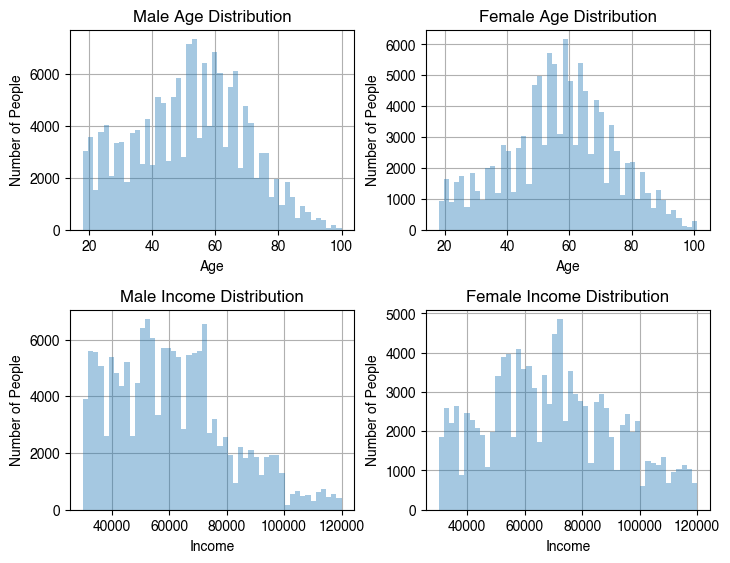

In [31]:
fig = plt.gcf()
fig.set_size_inches(8,6)
fig.tight_layout(pad=5.0)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.25,
                    hspace=0.4)

plt.subplot(221)
sns.distplot(df[df['gender']=='M']['age'], kde=False)
plt.ylabel('Number of People')
plt.xlabel('Age')
plt.title('Male Age Distribution')
plt.rc('axes', axisbelow=True)
plt.grid(True)

plt.subplot(222)
sns.distplot(df[df['gender']=='F']['age'], kde=False)
plt.ylabel('Number of People')
plt.xlabel('Age')
plt.title('Female Age Distribution')
plt.rc('axes', axisbelow=True)
plt.grid(True)

plt.subplot(223)
sns.distplot(df[df['gender']=='M']['income'], kde=False)
plt.ylabel('Number of People')
plt.xlabel('Income')
plt.title('Male Income Distribution')
plt.rc('axes', axisbelow=True)
plt.grid(True)

plt.subplot(224)
sns.distplot(df[df['gender']=='F']['income'], kde=False)
plt.ylabel('Number of People')
plt.xlabel('Income')
plt.title('Female Income Distribution')
plt.rc('axes', axisbelow=True)
plt.grid(True)

#### Q12: What is the distribution of age and income for customer gender and offer types in the dataframe?

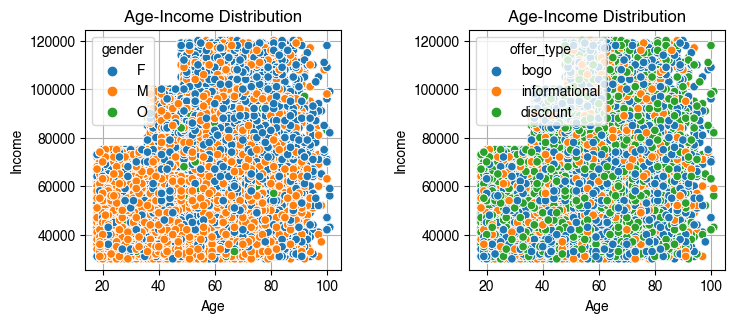

In [32]:
fig = plt.gcf()
fig.set_size_inches(8,3)
fig.tight_layout(pad=5.0)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.5,
                    hspace=0.4)

plt.subplot(121)
sns.scatterplot(x=df['age'], y=df['income'], hue=df['gender'], legend='full')
plt.xlabel('Age'); plt.ylabel('Income')
plt.title('Age-Income Distribution')
plt.rc('axes', axisbelow=True)
plt.grid(True)


plt.subplot(122)
sns.scatterplot(x=df['age'], y=df['income'], hue=df['offer_type'], legend='full')
plt.xlabel('Age'); plt.ylabel('Income')
plt.title('Age-Income Distribution')
plt.rc('axes', axisbelow=True)
plt.grid(True)

#### Q13: What is portion of offers received, viewed and completed?

In [33]:
offer_received = df['offer_received'].value_counts() 
offer_viewed = df['offer_viewed'].value_counts() / offer_received * 100
offer_completed = df['offer_completed'].value_counts() / offer_received * 100

print('Number of offers received in the dataset: ',"{:.2f}".format(offer_received[1]))
print('Percentage of offers viewed in the dataset: ',"{:.2f}".format(offer_viewed[1]))
print('Percentage of offers completed in the dataset: ',"{:.2f}".format(offer_completed[1]))


Number of offers received in the dataset:  76277.00
Percentage of offers viewed in the dataset:  75.68
Percentage of offers completed in the dataset:  44.02


#### Q14: What is variety of offers in the dataframe?

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


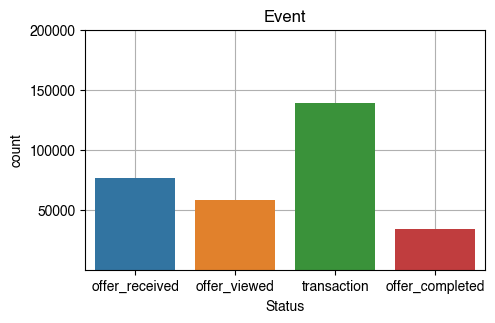

In [34]:
fig = plt.gcf()
fig.set_size_inches(5,3)
fig.tight_layout(pad=5.0)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

sns.countplot(df['event'])
plt.ylabel('count')
plt.xlabel('Status')
plt.title('Event')
plt.yticks([50000, 100000, 150000, 200000])
plt.grid(True)

#### Q15: What is the number of different event?

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an 

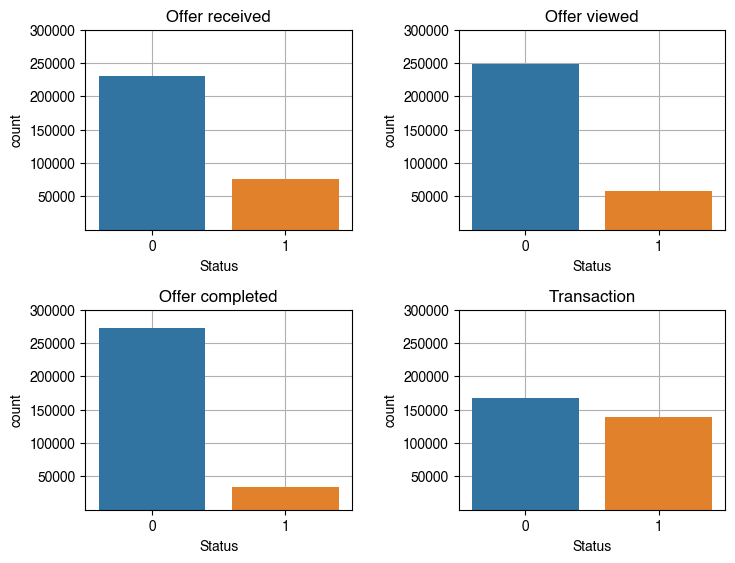

In [35]:
fig = plt.gcf()
fig.set_size_inches(8,6)
fig.tight_layout(pad=5.0)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

plt.subplot(221)
sns.countplot(df['offer_received'])
plt.ylabel('count')
plt.xlabel('Status')
plt.title('Offer received')
plt.yticks([50000, 100000, 150000, 200000, 250000, 300000])
plt.grid(True)

plt.subplot(222)
sns.countplot(df['offer_viewed'])
plt.xlabel('Status')
plt.title('Offer viewed')
plt.yticks([50000, 100000, 150000, 200000, 250000, 300000])
plt.grid(True)

plt.subplot(223)
sns.countplot(df['offer_completed'])
plt.xlabel('Status')
plt.title('Offer completed')
plt.yticks([50000, 100000, 150000, 200000, 250000, 300000])
plt.grid(True)

plt.subplot(224)
sns.countplot(df['transaction'])
plt.xlabel('Status')
plt.title('Transaction')
plt.yticks([50000, 100000, 150000, 200000, 250000, 300000])
plt.grid(True)

#### Step 8) Preprocessing the data for machine learning and making the model

In [36]:
# Encoding gender value in df to numeric values
genders = {'O': 0, 'M': 1, 'F': 2}
df['gender'] = df['gender'].map(genders)

# Encoding offers value in df to numeric values
offers = {'bogo': 0, 'discount': 1, 'informational': 2}
df['offer_type'] = df['offer_type'].map(offers)

# Encoding event status to numeric values
offer_status = {'offer_completed': 0, 'offer_received': 1, 'offer_viewed': 2, 'transaction': '3'}
df['offer_status'] = df['event']
df['offer_status'] = df['offer_status'].map(offer_status)

df.head(10)

,customer_id,event,time,offer_id,offer_completed,offer_received,offer_viewed,transaction,gender,age,...,day,reward,difficulty,duration,offer_type,email,mobile,social,web,offer_status
0,78afa995795e4d85b5d9ceeca43f5fef,offer_received,0,0,0,1,0,0,2.0,75,...,9,5.0,5.0,7.0,0.0,1.0,1.0,0.0,1.0,1
1,78afa995795e4d85b5d9ceeca43f5fef,offer_viewed,6,0,0,0,1,0,2.0,75,...,9,5.0,5.0,7.0,0.0,1.0,1.0,0.0,1.0,2
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,1,0,0,0,1,2.0,75,...,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,78afa995795e4d85b5d9ceeca43f5fef,offer_completed,132,1,1,0,0,0,2.0,75,...,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,1,0,0,0,1,2.0,75,...,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
5,78afa995795e4d85b5d9ceeca43f5fef,offer_received,168,2,0,1,0,0,2.0,75,...,9,0.0,0.0,3.0,2.0,1.0,1.0,1.0,0.0,1
6,78afa995795e4d85b5d9ceeca43f5fef,offer_viewed,216,2,0,0,1,0,2.0,75,...,9,0.0,0.0,3.0,2.0,1.0,1.0,1.0,0.0,2
7,78afa995795e4d85b5d9ceeca43f5fef,transaction,222,1,0,0,0,1,2.0,75,...,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
8,78afa995795e4d85b5d9ceeca43f5fef,transaction,240,1,0,0,0,1,2.0,75,...,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
9,78afa995795e4d85b5d9ceeca43f5fef,transaction,378,1,0,0,0,1,2.0,75,...,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3


In [37]:
df.describe()

,time,offer_id,offer_completed,offer_received,offer_viewed,transaction,gender,age,income,year,month,day,reward,difficulty,duration,offer_type,email,mobile,social,web
count,306534.000000,306534.000000,306534.000000,306534.000000,306534.000000,306534.000000,272762.000000,306534.000000,272762.000000,306534.000000,306534.000000,306534.000000,134002.000000,134002.000000,134002.000000,134002.000000,134002.0,134002.000000,134002.000000,134002.000000
mean,366.382940,2.972969,0.109544,0.248837,0.188315,0.453304,1.400092,60.909367,64337.000755,2016.476032,6.701710,15.886153,4.298570,7.494709,6.431426,0.777003,1.0,0.922904,0.659035,0.785981
std,200.326314,3.024581,0.312321,0.432340,0.390964,0.497815,0.518784,26.032030,21243.762941,1.199589,3.500048,8.765044,3.474138,5.183595,2.181338,0.749875,0.0,0.266744,0.474035,0.410142
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,30000.000000,2013.000000,1.000000,1.000000,0.000000,0.000000,3.000000,0.000000,1.0,0.000000,0.000000,0.000000
25%,186.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,43.000000,48000.000000,2016.000000,4.000000,8.000000,2.000000,5.000000,5.000000,0.000000,1.0,1.000000,0.000000,1.000000
50%,408.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,57.000000,62000.000000,2017.000000,7.000000,16.000000,3.000000,7.000000,7.000000,1.000000,1.0,1.000000,1.000000,1.000000
75%,528.000000,5.000000,0.000000,0.000000,0.000000,1.000000,2.000000,72.000000,78000.000000,2017.000000,10.000000,24.000000,5.000000,10.000000,7.000000,1.000000,1.0,1.000000,1.000000,1.000000
max,714.000000,10.000000,1.000000,1.000000,1.000000,1.000000,2.000000,118.000000,120000.000000,2018.000000,12.000000,31.000000,10.000000,20.000000,10.000000,2.000000,1.0,1.000000,1.000000,1.000000


#### Step 9) Filling invalid and missing values in the dataframe with some value that can be identified as missing values so the data of NaN data will keep in the model

In [38]:
# filling invallid and missing values in the dataframe with some value that can be identified as missing values so the data of NaN data will keep in the model
df.loc[df['age'] == 118, 'age'] = 118
df['reward'] = df['reward'].fillna(50)
df['difficulty'] = df['difficulty'].fillna(50)
df['duration'] = df['duration'].fillna(50)
df['offer_type'] = df['offer_type'].fillna(50)
df['email'] = df['email'].fillna(50)
df['mobile'] = df['mobile'].fillna(50)
df['social'] = df['social'].fillna(50)
df['web'] = df['web'].fillna(50)

df.head(10)


,customer_id,event,time,offer_id,offer_completed,offer_received,offer_viewed,transaction,gender,age,...,day,reward,difficulty,duration,offer_type,email,mobile,social,web,offer_status
0,78afa995795e4d85b5d9ceeca43f5fef,offer_received,0,0,0,1,0,0,2.0,75,...,9,5.0,5.0,7.0,0.0,1.0,1.0,0.0,1.0,1
1,78afa995795e4d85b5d9ceeca43f5fef,offer_viewed,6,0,0,0,1,0,2.0,75,...,9,5.0,5.0,7.0,0.0,1.0,1.0,0.0,1.0,2
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,1,0,0,0,1,2.0,75,...,9,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,3
3,78afa995795e4d85b5d9ceeca43f5fef,offer_completed,132,1,1,0,0,0,2.0,75,...,9,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,1,0,0,0,1,2.0,75,...,9,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,3
5,78afa995795e4d85b5d9ceeca43f5fef,offer_received,168,2,0,1,0,0,2.0,75,...,9,0.0,0.0,3.0,2.0,1.0,1.0,1.0,0.0,1
6,78afa995795e4d85b5d9ceeca43f5fef,offer_viewed,216,2,0,0,1,0,2.0,75,...,9,0.0,0.0,3.0,2.0,1.0,1.0,1.0,0.0,2
7,78afa995795e4d85b5d9ceeca43f5fef,transaction,222,1,0,0,0,1,2.0,75,...,9,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,3
8,78afa995795e4d85b5d9ceeca43f5fef,transaction,240,1,0,0,0,1,2.0,75,...,9,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,3
9,78afa995795e4d85b5d9ceeca43f5fef,transaction,378,1,0,0,0,1,2.0,75,...,9,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,3


In [39]:
df.loc[df['offer_completed'] == 0, 'offer_completed'] = 2
df.loc[df['offer_received'] == 0, 'offer_received'] = 2
df.loc[df['offer_viewed'] == 0, 'offer_viewed'] = 2
df.loc[df['transaction'] == 0, 'transaction'] = 2

#### Step 10) replacing the column with nan, so we can later remove them or replace them

In [40]:
# replacing the column with nan, so we can later remove them or replace them
for col in ['gender','age','income','reward','difficulty','duration','offer_type','email','mobile','social','web']:
        df[col] = df[col].fillna(df[col].mean())
        
df.head(5)       

,customer_id,event,time,offer_id,offer_completed,offer_received,offer_viewed,transaction,gender,age,...,day,reward,difficulty,duration,offer_type,email,mobile,social,web,offer_status
0,78afa995795e4d85b5d9ceeca43f5fef,offer_received,0,0,2,1,2,2,2.0,75,...,9,5.0,5.0,7.0,0.0,1.0,1.0,0.0,1.0,1
1,78afa995795e4d85b5d9ceeca43f5fef,offer_viewed,6,0,2,2,1,2,2.0,75,...,9,5.0,5.0,7.0,0.0,1.0,1.0,0.0,1.0,2
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,1,2,2,2,1,2.0,75,...,9,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,3
3,78afa995795e4d85b5d9ceeca43f5fef,offer_completed,132,1,1,2,2,2,2.0,75,...,9,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,1,2,2,2,1,2.0,75,...,9,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,3


In [41]:
df.describe()       

,time,offer_id,offer_completed,offer_received,offer_viewed,transaction,gender,age,income,year,month,day,reward,difficulty,duration,offer_type,email,mobile,social,web
count,306534.000000,306534.000000,306534.000000,306534.000000,306534.000000,306534.000000,306534.000000,306534.000000,306534.000000,306534.000000,306534.000000,306534.000000,306534.000000,306534.000000,306534.000000,306534.000000,306534.000000,306534.000000,306534.000000,306534.000000
mean,366.382940,2.972969,1.890456,1.751163,1.811685,1.546696,1.400092,60.909367,64337.000755,2016.476032,6.701710,15.886153,30.021521,31.418720,30.953904,28.482061,28.579544,28.545842,28.430491,28.485985
std,200.326314,3.024581,0.312321,0.432340,0.390964,0.497815,0.489372,26.032030,20039.365463,1.199589,3.500048,8.765044,22.785595,21.360858,21.659618,24.421374,24.305726,24.344607,24.476864,24.413394
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,18.000000,30000.000000,2013.000000,1.000000,1.000000,0.000000,0.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,186.000000,1.000000,2.000000,2.000000,2.000000,1.000000,1.000000,43.000000,50000.000000,2016.000000,4.000000,8.000000,5.000000,10.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,408.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000,57.000000,64337.000755,2017.000000,7.000000,16.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
75%,528.000000,5.000000,2.000000,2.000000,2.000000,2.000000,2.000000,72.000000,75000.000000,2017.000000,10.000000,24.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
max,714.000000,10.000000,2.000000,2.000000,2.000000,2.000000,2.000000,118.000000,120000.000000,2018.000000,12.000000,31.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000


Plotting the correlation matrix for different columns in the dataset

<AxesSubplot:>

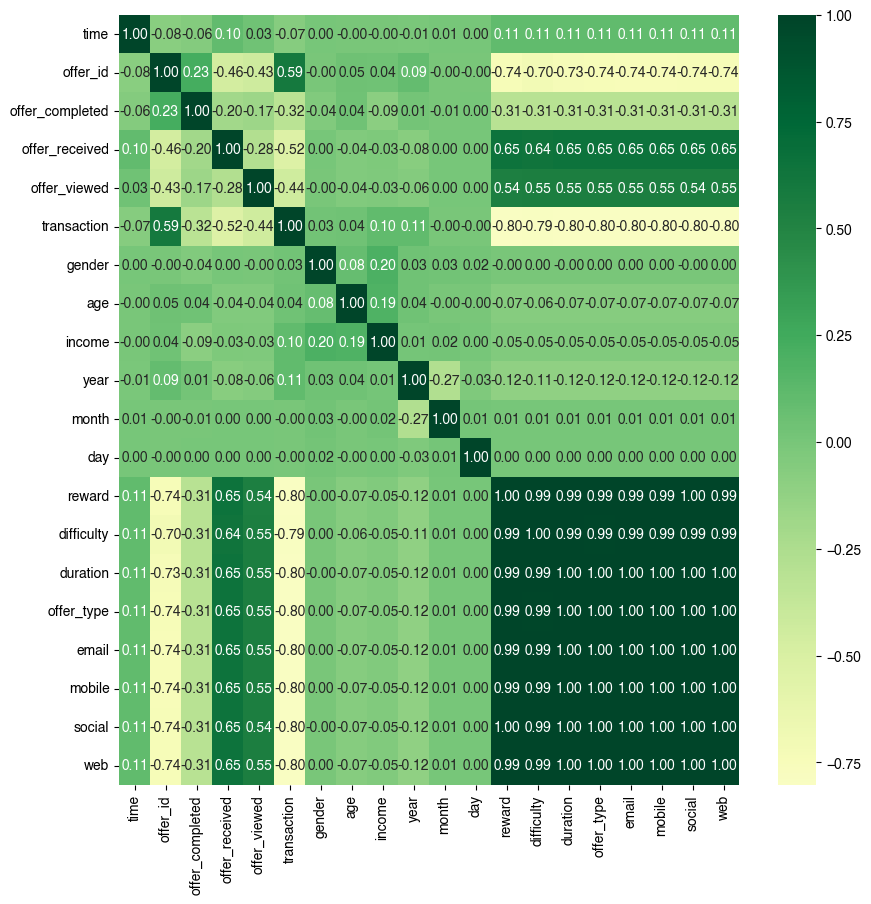

In [42]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df.corr(), annot = True, fmt = '.2f', center = 0, ax = ax, cmap= 'YlGn') 

In [43]:
df.head(10)

,customer_id,event,time,offer_id,offer_completed,offer_received,offer_viewed,transaction,gender,age,...,day,reward,difficulty,duration,offer_type,email,mobile,social,web,offer_status
0,78afa995795e4d85b5d9ceeca43f5fef,offer_received,0,0,2,1,2,2,2.0,75,...,9,5.0,5.0,7.0,0.0,1.0,1.0,0.0,1.0,1
1,78afa995795e4d85b5d9ceeca43f5fef,offer_viewed,6,0,2,2,1,2,2.0,75,...,9,5.0,5.0,7.0,0.0,1.0,1.0,0.0,1.0,2
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,1,2,2,2,1,2.0,75,...,9,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,3
3,78afa995795e4d85b5d9ceeca43f5fef,offer_completed,132,1,1,2,2,2,2.0,75,...,9,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,1,2,2,2,1,2.0,75,...,9,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,3
5,78afa995795e4d85b5d9ceeca43f5fef,offer_received,168,2,2,1,2,2,2.0,75,...,9,0.0,0.0,3.0,2.0,1.0,1.0,1.0,0.0,1
6,78afa995795e4d85b5d9ceeca43f5fef,offer_viewed,216,2,2,2,1,2,2.0,75,...,9,0.0,0.0,3.0,2.0,1.0,1.0,1.0,0.0,2
7,78afa995795e4d85b5d9ceeca43f5fef,transaction,222,1,2,2,2,1,2.0,75,...,9,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,3
8,78afa995795e4d85b5d9ceeca43f5fef,transaction,240,1,2,2,2,1,2.0,75,...,9,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,3
9,78afa995795e4d85b5d9ceeca43f5fef,transaction,378,1,2,2,2,1,2.0,75,...,9,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,3


#### Step 11) Preprocessing the dataset for modelling step (normalizing and configuring the input and output of the model)

In [44]:
#  Normlaizing the data for modelling the data
scaler = MinMaxScaler()

for col in ['gender','age','income','reward','difficulty','duration','offer_type','mobile','social','web','offer_id','offer_received','offer_completed','offer_viewed']:
    df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1))
    
X = df.drop(['customer_id', 'became_member_on','offer_completed',
       'offer_viewed', 'transaction','time', 'email','mobile','social','web','month','year','day', 'event'], axis=1) #'offer_type',

Y = df['offer_completed']

In [45]:
X.describe()

,offer_id,offer_received,gender,age,income,reward,difficulty,duration,offer_type
count,306534.000000,306534.000000,306534.000000,306534.000000,306534.000000,306534.000000,306534.000000,306534.000000,306534.000000
mean,0.297297,0.751163,0.700046,0.429094,0.381522,0.600430,0.628374,0.594764,0.569641
std,0.302458,0.432340,0.244686,0.260320,0.222660,0.455712,0.427217,0.460843,0.488427
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.100000,1.000000,0.500000,0.250000,0.222222,0.100000,0.200000,0.085106,0.020000
50%,0.100000,1.000000,0.500000,0.390000,0.381522,1.000000,1.000000,1.000000,1.000000
75%,0.500000,1.000000,1.000000,0.540000,0.500000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [46]:
Y.head(5)

0    1.0
1    1.0
2    1.0
3    0.0
4    1.0
Name: offer_completed, dtype: float64

#### Step 12) Splitting the dataset into test and train datasets

In [47]:
# Splitting the dataset into test and train datasets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)


X_train.reset_index(inplace=True)
X_train = X_train.drop(['index'], axis=1)

In [48]:
# Correlation of input vector
X_train.corr()

,offer_id,offer_received,gender,age,income,reward,difficulty,duration,offer_type
offer_id,1.000000,-0.459903,0.000333,0.048095,0.037717,-0.736234,-0.698864,-0.727548,-0.738652
offer_received,-0.459903,1.000000,0.002444,-0.035795,-0.026214,0.652133,0.639032,0.649468,0.652034
gender,0.000333,0.002444,1.000000,0.084028,0.198314,-0.000931,-0.000671,-0.001038,-0.001030
age,0.048095,-0.035795,0.084028,1.000000,0.191588,-0.066084,-0.065154,-0.065841,-0.065775
income,0.037717,-0.026214,0.198314,0.191588,1.000000,-0.049098,-0.047644,-0.048605,-0.049044
reward,-0.736234,0.652133,-0.000931,-0.066084,-0.049098,1.000000,0.989797,0.993541,0.992975
difficulty,-0.698864,0.639032,-0.000671,-0.065154,-0.047644,0.989797,1.000000,0.993277,0.985631
duration,-0.727548,0.649468,-0.001038,-0.065841,-0.048605,0.993541,0.993277,1.000000,0.997280
offer_type,-0.738652,0.652034,-0.001030,-0.065775,-0.049044,0.992975,0.985631,0.997280,1.000000


In [49]:
X_train

,offer_id,offer_received,gender,age,income,reward,difficulty,duration,offer_type,offer_status
0,0.9,1.0,1.000000,0.67,0.411111,0.20,0.2,0.042553,0.00,2
1,0.1,1.0,1.000000,0.73,0.555556,1.00,1.0,1.000000,1.00,3
2,0.1,1.0,1.000000,0.39,0.722222,1.00,1.0,1.000000,1.00,3
3,0.8,0.0,0.700046,1.00,0.381522,0.04,0.2,0.148936,0.02,1
4,0.1,1.0,1.000000,0.36,0.633333,1.00,1.0,1.000000,1.00,0
...,...,...,...,...,...,...,...,...,...,...
214568,0.0,0.0,1.000000,0.46,0.988889,0.10,0.1,0.085106,0.00,1
214569,0.0,0.0,0.500000,0.27,0.277778,0.10,0.1,0.085106,0.00,1
214570,0.1,1.0,1.000000,0.30,0.088889,1.00,1.0,1.000000,1.00,3
214571,0.3,1.0,1.000000,0.77,0.022222,0.20,0.2,0.085106,0.00,2


#### Step 13)  Setup different classifiers for modelling the data

##### 1) Random Forest Classifier

accuracy score is:  0.8892682767695002
[[    0 10183]
 [    0 81778]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     10183
         1.0       0.89      1.00      0.94     81778

    accuracy                           0.89     91961
   macro avg       0.44      0.50      0.47     91961
weighted avg       0.79      0.89      0.84     91961



Text(0.5, 1.0, 'Confusion Matrix')

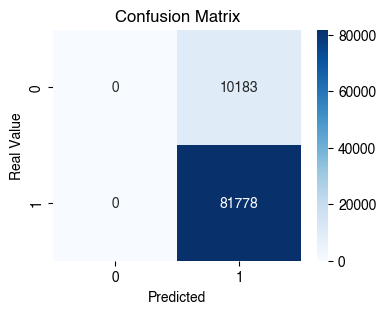

In [50]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_jobs = -1, max_features = 'sqrt',
                             max_depth = 20, min_samples_split = 2,
                             n_estimators = 2, max_samples = 5,
                             criterion = 'gini', random_state = 42, 
                             oob_score = True, bootstrap=True, 
                             class_weight=None)

clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
confusion = confusion_matrix(y_test,y_pred)
print('accuracy score is: ',accuracy_score(y_test,y_pred))
print(confusion)
print(classification_report(y_test,y_pred, zero_division=0))

fig = plt.gcf()
fig.set_size_inches(4,3)
sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, fmt='g')
plt.ylabel('Real Value')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')

##### 2) KNeighborsClassifier Model

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


accuracy score is:  1.0
[[10183     0]
 [    0 81778]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10183
         1.0       1.00      1.00      1.00     81778

    accuracy                           1.00     91961
   macro avg       1.00      1.00      1.00     91961
weighted avg       1.00      1.00      1.00     91961



Text(0.5, 3.722222222222216, 'Predicted')

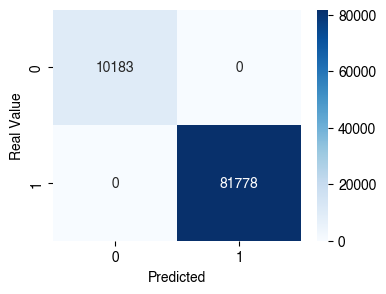

In [51]:
# KNeighborsClassifier Model
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
confusion = confusion_matrix(y_test,y_pred)
print('accuracy score is: ',accuracy_score(y_test,y_pred))
print(confusion)
print(classification_report(y_test,y_pred, zero_division=0))

fig = plt.gcf()
fig.set_size_inches(4,3)
sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, fmt='g')
plt.ylabel('Real Value')
plt.xlabel('Predicted')

##### 3) Gaussian Naive Bayesian

accuracy score is:  1.0
[[10183     0]
 [    0 81778]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10183
         1.0       1.00      1.00      1.00     81778

    accuracy                           1.00     91961
   macro avg       1.00      1.00      1.00     91961
weighted avg       1.00      1.00      1.00     91961



Text(0.5, 3.722222222222216, 'Predicted')

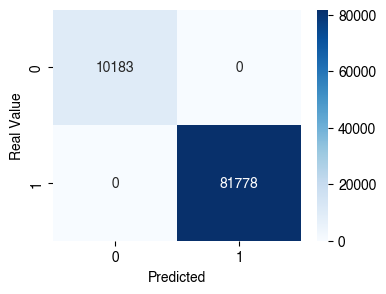

In [52]:
# Gaussian Naive Bayesian
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
confusion = confusion_matrix(y_test,y_pred)
print('accuracy score is: ',accuracy_score(y_test,y_pred))
print(confusion)
print(classification_report(y_test,y_pred, zero_division=0))

fig = plt.gcf()
fig.set_size_inches(4,3)
sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, fmt='g')
plt.ylabel('Real Value')
plt.xlabel('Predicted')

##### 4) Support Vector Machine

accuracy score is:  1.0
[[10183     0]
 [    0 81778]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10183
         1.0       1.00      1.00      1.00     81778

    accuracy                           1.00     91961
   macro avg       1.00      1.00      1.00     91961
weighted avg       1.00      1.00      1.00     91961



Text(0.5, 3.722222222222216, 'Predicted')

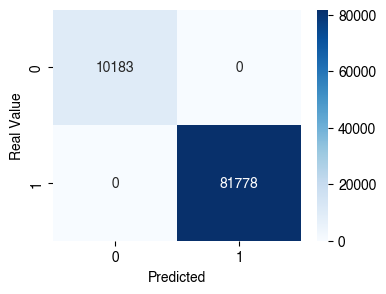

In [53]:
# Support Vector Machine
from sklearn.svm import SVC

clf = SVC()
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
confusion = confusion_matrix(y_test,y_pred)
print('accuracy score is: ',accuracy_score(y_test,y_pred))
print(confusion)
print(classification_report(y_test,y_pred))

fig = plt.gcf()
fig.set_size_inches(4,3)
sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, fmt='g')
plt.ylabel('Real Value')
plt.xlabel('Predicted')

##### 5) Decision Tree Classifier

accuracy score is:  1.0
[[10183     0]
 [    0 81778]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10183
         1.0       1.00      1.00      1.00     81778

    accuracy                           1.00     91961
   macro avg       1.00      1.00      1.00     91961
weighted avg       1.00      1.00      1.00     91961



Text(0.5, 3.722222222222216, 'Predicted')

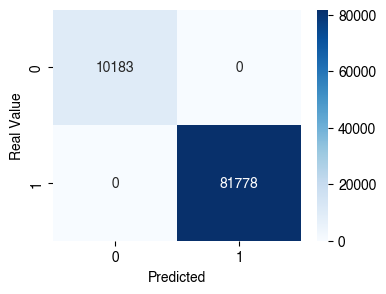

In [54]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth = 2, 
                             min_samples_split = 2,
                             splitter = 'best',
                             criterion = 'gini',
                             max_features = 5,
                             random_state = 40)

clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
confusion = confusion_matrix(y_test,y_pred)
print('accuracy score is: ',accuracy_score(y_test,y_pred))
print(confusion)
print(classification_report(y_test,y_pred, zero_division=0))

fig = plt.gcf()
fig.set_size_inches(4,3)
sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, fmt='g')
plt.ylabel('Real Value')
plt.xlabel('Predicted')

##### 6) Multi-layer Perceptron Classifier

accuracy score is:  1.0
1.0
[[10183     0]
 [    0 81778]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10183
         1.0       1.00      1.00      1.00     81778

    accuracy                           1.00     91961
   macro avg       1.00      1.00      1.00     91961
weighted avg       1.00      1.00      1.00     91961



Text(0.5, 3.722222222222216, 'Predicted')

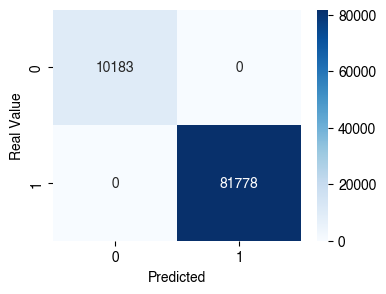

In [55]:
# Multi-layer Perceptron Classifier
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes = (10,10),
                    solver = 'sgd',
                    momentum = 0.5,
                    activation = 'relu',
                    max_iter=100000)

clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
confusion = confusion_matrix(y_test,y_pred)
print('accuracy score is: ',accuracy_score(y_test,y_pred))
print(clf.score(X_train, y_train))
print(confusion)
print(classification_report(y_test,y_pred, zero_division=0))

fig = plt.gcf()
fig.set_size_inches(4,3)
sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, fmt='g')
plt.ylabel('Real Value')
plt.xlabel('Predicted')

##### 6) Logistic Regression

accuracy score is:  1.0
[[10183     0]
 [    0 81778]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10183
         1.0       1.00      1.00      1.00     81778

    accuracy                           1.00     91961
   macro avg       1.00      1.00      1.00     91961
weighted avg       1.00      1.00      1.00     91961



Text(0.5, 3.722222222222216, 'Predicted')

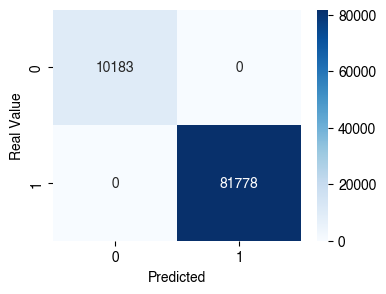

In [56]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
confusion = confusion_matrix(y_test,y_pred)
print('accuracy score is: ',accuracy_score(y_test,y_pred))
print(confusion)
print(classification_report(y_test,y_pred, zero_division=0))

fig = plt.gcf()
fig.set_size_inches(4,3)
sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, fmt='g')
plt.ylabel('Real Value')
plt.xlabel('Predicted')